<img src="http://www.ensai.fr/files/_media/images/l_ecole/Partenaires/Ecoles/ensae_logo_dev.png" width="400" height="80" />
<br>
<div class="monika" align="center" style="font-size:200%"> Stochastic Optimization and Automatic Differentiation for Machine Learning </div>
<br>
<div style="text-align: center"> Selim Dekali & Mathis Linger </div>

In [95]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

### 1] Introduction

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.datasets.samples_generator import make_blobs
from sklearn.svm import LinearSVC
import sklearn.metrics.pairwise as kernel
from sklearn.model_selection import train_test_split
from sklearn import metrics
import timeit
import collections

Consider:
- $x_1,..., x_n$ $\in$ $\mathbb{R}^d$
- $y_1,...,y_n$ $\in$ $(-1, 1)$
- $\lambda > 0$ a regularization parameter
- $\phi_1,...,\phi_n$ a sequence of scalars convex functions
- Since we are working on the SVM problem (with linear kernels and no bias term), we set $\phi_i(a) = max(0,1-y_ia)$ (Hinge loss)

For solving SVM, there are 2 approaches:
- stochastic gradient descent (SGD), which aims to minimize the following primal problem:
\begin{equation}
min_{w \text{ } \in \text{ } R^d} \big[ \frac{1}{n} \sum\limits_{i=1}^n \phi_i(w^Tx_i) + \frac{\lambda}{2}||w||^2\big]
\end{equation}
- dual coordinate ascent (DCA), which aims to maximize the following dual problem:
\begin{equation}
max_{\alpha \text{ } \in \text{ } R^n} \big[ \frac{1}{n} \sum\limits_{i=1}^n -\phi_i^*(-\alpha_i) - \frac{\lambda}{2} \big|\big|\frac{1}{\lambda n}\sum\limits_{i=1}^n \alpha_i x_i \big|\big|^2\big]
\end{equation}
here, for each $i$, $\phi_i^*: \mathbb{R} \rightarrow \mathbb{R}$ is the convex conjugate of $\phi_i$, namely $\phi_i^*(u) = max_z(zu - \phi_i(z))$

If we define, $w(\alpha) = \frac{1}{\lambda n}\sum\limits_{i=1}^n \alpha_i x_i$, then we have that $w(\alpha^*) = w^*$ where $\alpha^*$ is an optimal solution of the dual problem.

### 2] Dual coordinate ascent for SVM

#### a) SDCA

***
<center>___SDCA___</center>
***
___Let___ $w^{(0)} = w(\alpha^{(0)})$<br>
___Iterate:___ for $t=1,2,...,T:$
> Randomly pick $i$<br>
Find $\Delta\alpha_i$ to maximize $-\phi_i^*(-(\alpha_i^{(t-1)}+\Delta\alpha_i)) - \frac{\lambda n}{2} ||w^{(t-1)}+(\lambda n)^{-1} \Delta\alpha_ix_i||^2$<br>
$\alpha^{(t)} \leftarrow \alpha^{(t-1)}+\Delta\alpha_ie_i$<br>
$w^{(t)} \leftarrow w^{(t-1)}+(\lambda n)^{-1}\Delta\alpha_ix_i$<br>
 
___Output (Averaging option):___<br>
> Let $\bar{\alpha} = \frac{1}{T-T_0}\sum\limits_{i=T_0+1}^T \alpha^{(t-1)}$<br>
Let $\bar{w} = w(\bar{\alpha}) = \frac{1}{T-T_0}\sum\limits_{i=T_0+1}^T w^{(t-1)}$<br>
return $\bar{w}$<br>

___Output (Random option):___<br>
> Let $\bar{\alpha} = \alpha^{(t)}$ and $\bar{w} = w^{(t)}$ for some random $t \in T_0+1,...T$<br>
return $\bar{w}$

***

___Close formula to maximize $-\phi_i^*(-(\alpha_i^{(t-1)}+\Delta\alpha_i)) - \frac{\lambda n}{2} ||w^{(t-1)}+(\lambda n)^{-1} \Delta\alpha_ix_i||^2$:___

We want to $max_{\alpha \text{ } \in \text{ } R^n} D(\alpha)$ with $D(\alpha) = \frac{1}{n} \sum\limits_{i=1}^n -\phi_i^*(-\alpha_i) - \frac{\lambda}{2} \big|\big|\frac{1}{\lambda n}\sum\limits_{i=1}^n \alpha_i x_i \big|\big|^2 = - \frac{1}{2\lambda n^2} \alpha^T X^T X \alpha + \frac{1}{n} \sum\limits_{i=1}^n -\phi_i^*(-\alpha_i)$

At each iteration, we have to maximize the updated dual objective defined as:
\begin{equation}
\begin{aligned}
D(\alpha_t+\Delta\alpha_i e_i) = &\frac{-1}{2\lambda n^2} (\alpha_t+\Delta\alpha_i e_i)^T X^T X (\alpha_t+\Delta\alpha_i e_i) - \frac{1}{n}\sum\limits_{i=1}^n \phi_i^*(-\alpha_t-\Delta\alpha_i e_i)\\
=& \frac{-1}{2\lambda n^2} \alpha_t^T X^T X \alpha_t - \frac{1}{\lambda n^2} \alpha_t^T X^T X \Delta\alpha_ie_i - \frac{1}{2\lambda n^2} (\Delta\alpha_i e_i)^T X^T X (\Delta\alpha_i e_i) - \frac{1}{n}\sum\limits_{i=1}^n \phi_i^*(-\alpha_t-\Delta\alpha_i e_i)\\
\end{aligned}
\end{equation}

By setting:
\begin{equation}
\begin{aligned}
Constant =& \frac{-1}{2\lambda n^2} \alpha_t^T X^T X \alpha_t - \frac{1}{n}\sum\limits_{\substack{i=1 \\ i\neq j}}^n \phi_j^*(-\alpha_t-\Delta\alpha_j e_j)\\
A =& \frac{1}{\lambda n} x_i^T x_i = \frac{1}{\lambda n}||x_i||^2\\
B=& x_i^T \frac{X \alpha_t}{\lambda n} = x_i^T w_t
\end{aligned}
\end{equation}

we get:
\begin{equation}
\begin{aligned}
D(\alpha_t+\Delta\alpha_i e_i) \propto \frac{-A}{2} (\Delta\alpha_i)^2 - B \Delta\alpha_i - \phi^*_i(-\alpha_i\Delta\alpha_i)
\end{aligned}
\end{equation}

We recall that in the case of SVM, we use the Hinge loss, i.e.:
\begin{equation}
\phi_i(a) = max(0,1-y_ia)
\end{equation}
and its conjugate is given by:
\begin{equation}
\phi^*_i(u) =
    \begin{cases}
      y_i u & \text{if} -1\leq y_iu\leq 0\\
      +\infty & \text{otherwise}
    \end{cases} 
\end{equation}

Then, considering that $-1\leq y_iu\leq 0$, we can maximize $D(\alpha_t+\Delta\alpha_i e_i)$ by $\Delta\alpha_i$ by:
\begin{equation}
\tilde{\Delta\alpha_i} = \frac{y_i -B}{A}
\end{equation}

Finally, if we incorporate the constraint $-1\leq -y_i(\alpha_i + \Delta\alpha_i)\leq 0 \leftrightarrow 0\leq y_i(\alpha_i + \Delta\alpha_i)\leq 1$, we obtain the update:
\begin{equation}
\Delta\alpha_i = \frac{1}{y_i}max(0, min(1, y_i(\alpha_i + \tilde{\Delta\alpha_i}))) - \alpha_i
\end{equation}

In [97]:
def dual_primal(alpha, X, lambda_):
    return X.T.dot(alpha)/(lambda_*X.shape[0])

In this implementation, we set $T_0 = \frac{T}{2}$ for the averaging option as suggested in the paper.

In [98]:
def SDCA(X, y, lambda_ = 1, nb_iteration = 100000, output = 'averaging'):
    weight_list = []
    n = X.shape[0]
    alpha = [np.zeros(n)]
    w = [dual_primal(alpha[0], X, lambda_)]
    for t in tqdm(range(nb_iteration)):
        i = np.random.randint(0, n)
        A = (1/(lambda_*n))*np.linalg.norm(X[i], 2)**2
        B = X[i].dot(w[t])
        delta_alpha = (y[i]-B)/A
        delta_alpha_constrained = (1/y[i])*max(0, min(1, y[i]*(delta_alpha+alpha[t][i]))) - alpha[t][i]
        e_i = np.zeros(n)
        e_i[i] = 1.
        alpha.append(alpha[t]+delta_alpha_constrained*e_i)
        w.append(dual_primal(alpha[t+1], X, lambda_))
        # Condition to store the weights at each epoch
        if t%n==0:
            if output == 'averaging':
                weight_list.append(np.mean(w[int(t/2):], axis = 0))
            else:
                weight_list.append(w[np.random.randint(int(t/2), t)])
    return weight_list

#### b) SDCA Mini-Batches

We found a paper proposing a mini batch version of SDCA. We can implement it in order to compare with the stochastic version. The paper is available at https://pdfs.semanticscholar.org/b0b5/13b601e28db45a02ed4b19801af0cb29e462.pdf#page3.

Original optimization problem:
$$
\begin{aligned}
&\min_{w,b} \frac{\lambda}{2} w.w \\
& \text{subject to : } (w.x_j) y_j \geq 1 \forall j
\end{aligned}
$$

We will use the Lagragian to solve the problem:
$$
L(w,\alpha) = n\big( \frac{\lambda}{2}w.w - \sum_{j} \alpha_j \big[(w.x_j+b)y_j-1 \big]\big)
$$
Our goal now is to solve: $$\min_{w,b} \max_{\alpha} L(w, \alpha) $$
(primal) :  $$ \min_{w,b} \max_{\alpha} n \big(\frac{\lambda}{2}w.w - \sum_{j} \alpha_j \big[(w.x_j+b)y_j-1 \big]\big)$$

(dual) : $$ \max_{\alpha} \min_{w,b} n \big( \frac{\lambda}{2}w.w - \sum_{j} \alpha_j \big[(w.x_j+b)y_j-1 \big]\big)$$

Can solve for optimal $w$, $b$ as function of $\alpha$:
$$\frac{\partial L}{\partial w} = \lambda n w - \sum_{j} \alpha_j x_j y_j \rightarrow w = \frac{\sum_{j} \alpha_j x_j y_j}{\lambda n}$$
$$\frac{\partial L}{\partial b} = - \sum_{j} \alpha_j y_j \rightarrow  \sum_{j} \alpha_j y_j = 0 $$
Substituting these values back in (and simplifying), we obtain:
$$ \max_{\alpha, \sum_{j}\alpha_j y_j =0} \frac{1}{n} \sum_{j} \alpha_j - \frac{1}{2 \lambda n^2} \sum_{i,j} y_i y_j \alpha_i \alpha_j (x_i.x_j)$$



Then, using the definition of the Gram matrix, i.e. Q is the matrix such that $Q_{i,j} = y_iy_j \langle x_i,x_j\rangle$, the problem rewrites:

$$ \max_{\alpha \in \mathbb{R}^{n\times n}, 0\leq\alpha_i\leq 1} \frac{1}{n} \sum_{i} \alpha_i - \frac{1}{2 \lambda n^2} \alpha^T Q \alpha$$

Now, at each iteration, aim to maximize the updated dual objective (as in the previous SDCA algorithm) defined as:
$$ D(\alpha + \delta) = \frac{1}{n} \sum_{i} (\alpha_i + \delta_i) - \frac{1}{2 \lambda n^2} (\alpha + \delta)^T Q (\alpha + \delta) = \frac{1}{n} \sum_{i} (\alpha_i + \delta_i) - \frac{(\alpha^T Q \alpha) + 2 \alpha^T Q \delta + \delta^T Q \delta}{2 \lambda n^2}$$

But instead of choosing $\delta$ by maximizing $D(\alpha + \delta)$, we will work with the Expected Separable Underapproximation:
$$ H(\delta, \alpha) =  \frac{1}{n} \sum_{i} (\alpha_i + \delta_i) - \frac{(\alpha^T Q \alpha) + 2 \alpha^T Q \delta + \beta_k ||\delta||^2}{2 \lambda n^2}$$
where $\beta_k$ is given below the following algorithm.

In the paper, the use of this approximation is justified by the proof that $H(\delta, \alpha)$ provides an expected lower bound on $D(\alpha + \delta)$.

***
<center>___SDCA with Mini-Batches___</center>
***
___Let___ $w^{(0)} = w(\alpha^{(0)})$, $\gamma = 0.95$, $\beta^{(0)} = \beta_k$ using (1)<br>
___Iterate:___ for $t=0,1,...,T:$
> Randomly pick $A_t \subseteq [n]$, where $|A_t|=k$<br>
For $i \in A_t$, compute $\tilde{\delta}_i$ from (2) using $\beta = \beta^{(t)}$<br>
Sum $\zeta := \sum\limits_{i \in A_t} \tilde{\delta}_i^2$ and $\tilde{\Delta} := \sum\limits_{i \in A_t} \tilde{\delta}_i y_i x_i$<br>
Compute $\rho = \text{clip}_{[1, \beta_k]}(\frac{||\tilde{\Delta}||^2}{\zeta})$<br>
For $i \in A_t$, compute $\delta_i$ from (2) using $\beta = \rho$<br>
$\beta^{(t+1)} := (\beta^{(t)})^{\gamma} \rho^{1-\gamma}$<br>
if $D(\alpha^{(t)} + \gamma_{[A_t]}) > D(\alpha^{(t)})$ then<br>
&nbsp;&nbsp;&nbsp;&nbsp; $\alpha^{(t+1)} = \alpha^{(t)}+\delta_{[A_t]}$<br>
&nbsp;&nbsp;&nbsp;&nbsp; $w^{(t+1)} = w^{(t)}+\frac{1}{\lambda n} \sum\limits_{i \in A_t} \delta_i y_i x_i$<br>
else<br>
&nbsp;&nbsp;&nbsp;&nbsp; $\alpha^{(t+1)} = \alpha^{(t)}$<br>
&nbsp;&nbsp;&nbsp;&nbsp; $w^{(t+1)} = w^{(t)}$<br>
 
___Output:___<br>
> return $w_T$

***


• (1): $\beta_k = 1+\frac{(k-1)(n\sigma^2-1)}{n-1}$ where $\sigma^2 \geq \frac{1}{n}||Q||$

$Q \in \mathbb{R}^{n\times n}$ is the Gram matrix of the labeled data where $Q_{i,j} = y_iy_j \langle x_i,x_j\rangle$

• (2): $\delta_i^{(t)} = \text{clip}_{[-\alpha_i^{(t)}, 1 - \alpha_i^{(t)}]} \frac{\lambda n (1-y_i \langle w(\alpha^{(t)}),x_i\rangle)}{\beta}$

In [99]:
def dual_loss(alpha_, Q_, lambda_, n):
    return -alpha_.T.dot(Q_).dot(alpha_) / (2*lambda_*n**2) + np.mean(alpha_)

In [100]:
# This is the function on which I try
def SDCA_mini_batch(X, y, k = 10, lambda_ = 1, gamma = .95, nb_iteration = 100000, output = 'averaging'):
    weight_list = []
    n = X.shape[0]
    alpha = [np.zeros(n)]
    w = [dual_primal(alpha[0], X, lambda_)]
    Q = (y.reshape((1,-1)).T.dot(y.reshape((1,-1)))) * (X.dot(X.T))
    beta_k = 1 + (k-1)*(np.linalg.norm(Q, 2)-1) / (n-1)
    beta = 1 + (k-1)*(np.linalg.norm(Q, 2)-1) / (n-1)
    for t in tqdm(range(nb_iteration)):
        A = np.random.choice(np.arange(n), size=k, replace=False)
        delta_tilde = np.array([np.clip(lambda_*n*(1-y[i]*X[i].dot(w[t])) / beta, -alpha[t][i], 1-alpha[t][i]) for i in A])
        zeta = delta_tilde.dot(delta_tilde)
        Delta_tilde = np.sum([delta_tilde[i]*y[j]*X[j] for i, j in enumerate(A)], axis = 1)
        rho = np.clip(np.linalg.norm(Delta_tilde, 2) / zeta, 1, beta_k)
        delta_A = np.array([np.clip(lambda_*n*(1-y[i]*X[i].dot(w[t])) / rho, -alpha[t][i], 1-alpha[t][i]) for i in A])
        beta = beta**gamma * rho**(1-gamma)
        delta = np.zeros(n)
        delta[A] += delta_A
        if dual_loss(alpha[t]+delta, Q, lambda_, n) > dual_loss(alpha[t], Q, lambda_, n):
            alpha.append(alpha[t]+delta)
            w.append(w[t] + (1 / (lambda_*n)) * (delta*y).dot(X))
        else:
            alpha.append(alpha[t])
            w.append(w[t])
        # Condition to store the weights at each epoch
        if (t*k)%n==0:
            if output == 'averaging':
                weight_list.append(np.mean(w[int(t/2):], axis = 0))
            else:
                weight_list.append(w[np.random.randint(int(t/2), t)])
    return weight_list

#### c) SDCA Perm

SDCA Perm uses the same logic as SDCA except that at the beginning of each epoch we shuffle the observations (i.e we perform a random permutation of {1,...,n}).

***
<center>___SDCA-Perm___</center>
***
___Let___ $w^{(0)} = w(\alpha^{(0)})$<br>
___Let___ $t=0$<br>
___Iterate:___ for epoch $k=1,2,...$<br>
> ___Let___ ${i_1,...,i_n}$ be a random permutation of ${1,...,n}$<br>
___Iterate:___ for $j=1,2,...,n:$<br>
&nbsp;&nbsp;&nbsp;&nbsp; $t \leftarrow t+1$<br>
&nbsp;&nbsp;&nbsp;&nbsp; $i=i_j$<br>
&nbsp;&nbsp;&nbsp;&nbsp; Find $\Delta\alpha_i$ to increase dual<br>
&nbsp;&nbsp;&nbsp;&nbsp; $\alpha^{(t)} \leftarrow \alpha^{(t-1)}+\Delta\alpha_ie_i$<br>
&nbsp;&nbsp;&nbsp;&nbsp; $w^{(t)} \leftarrow w^{(t-1)}+(\lambda n)^{-1}\Delta\alpha_ix_i$<br>
 
___Output (Averaging option):___<br>
> Let $\bar{\alpha} = \frac{1}{T-T_0}\sum\limits_{i=T_0+1}^T \alpha^{(t-1)}$<br>
Let $\bar{w} = w(\bar{\alpha}) = \frac{1}{T-T_0}\sum\limits_{i=T_0+1}^T w^{(t-1)}$<br>
return $\bar{w}$<br>

___Output (Random option):___<br>
> Let $\bar{\alpha} = \alpha^{(t)}$ and $\bar{w} = w^{(t)}$ for some random $t \in T_0+1,...T$<br>
return $\bar{w}$

***

In [101]:
def SDCA_perm(X, y, lambda_ = 1, nb_iteration = 100000, output = 'averaging'):
    weight_list = []
    n = X.shape[0]
    alpha = [np.zeros(n)]
    w = [dual_primal(alpha[0], X, lambda_)]
    indices = [shuffle([k for k in range(n)]) for m in range(int(nb_iteration/n))]
    indices = sum(indices, [])
    for t in tqdm(range(nb_iteration)):
        i = indices[t]
        A = (1/(lambda_*n))*np.linalg.norm(X[i], 2)**2
        B = X[i].dot(w[t])
        delta_alpha = (y[i]-B)/A
        delta_alpha_constrained = (1/y[i])*max(0, min(1, y[i]*(delta_alpha+alpha[t][i]))) - alpha[t][i]
        e_i = np.zeros(n)
        e_i[i] = 1.
        alpha.append(alpha[t]+delta_alpha_constrained*e_i)
        w.append(dual_primal(alpha[t+1], X, lambda_))
        # Condition to store the weights at each epoch
        if t%n==0:
            if output == 'averaging':
                weight_list.append(np.mean(w[int(t/2):], axis = 0))
            else:
                weight_list.append(w[np.random.randint(int(t/2), t)])
    return weight_list

### 3] Stochastic gradient descent for SVM

#### a) Pegasos

The Pegasos algorithm performs stochastic gradient descent on the primal objective.

***
<center>___Basic Pegasos algorithm___</center>
***
___Let___ $w^{(0)} = 0$<br>
___Iterate:___ for $t=1,2,...,T:$
> Randomly pick $i$<br>
Set $\eta_t = \frac{1}{\lambda t}$<br>
If $y_i \langle\, w_{t-1},x_i\rangle < 1$:<br>
&nbsp;&nbsp;&nbsp;&nbsp; $w_t \leftarrow (1-\eta_t \lambda)w_{t-1} + \eta_t y_i x_i$<br>
Else:<br>
&nbsp;&nbsp;&nbsp;&nbsp; $w_t \leftarrow (1-\eta_t \lambda)w_{t-1}$<br>
[Optional: $w_t \leftarrow min\big\{1, \frac{1/\sqrt{\lambda}}{||w_t||}\big\}w_t$]

 
___Output:___<br>
> return $w_T$

***

To use this algorithm, we need to compute the subgradient of the penalized hinge loss:
\begin{equation}
f(w; i_t) = \frac{\lambda}{2}||w||^2 + max(0, 1-y_{i_t} \langle\,w, x_{i_t}\rangle)
\end{equation}

It is givent by:
\begin{equation}
\bigtriangledown_t =
    \begin{cases}
      \lambda w_t - y_{i_t} x_{i_t} & \text{if } y_{i_t} \langle\,w, x_{i_t}\rangle < 1 \\
      \lambda w_t  & \text{otherwise}
    \end{cases} 
\end{equation}

We can add the optional projection step to the previous algorithm to limit the set of admissible solutions to the ball of radius $\frac{1}{\sqrt{\lambda}}$. However, in the experiments, there is no major differences between the projected and unprojected variants of Pegasos.

In [127]:
def Pegasos(X, y, z, lambda_ = 1, nb_iteration = 100000, projection = False):
    weight_list = []
    n = X.shape[0]
    w = [np.repeat(0, X.shape[1])]
    for t in tqdm(range(1,nb_iteration+1)):
        i = np.random.randint(0, n)
        eta = 1/(lambda_ * t *z)
        if y[i]*w[t-1].dot(X[i]) < 1:
            w_inter = (1-eta*lambda_)*w[t-1] + eta * y[i] * X[i]
        else:
            w_inter = (1-eta*lambda_)*w[t-1]
        if projection:
            w.append(min(1, (1/np.sqrt(lambda_))/np.linalg.norm(w_inter, 2))*w_inter)
        else:
            w.append(w_inter)
        if t%n == 0:
            weight_list.append(w[-1])
    return weight_list

#### b) Pegasos Mini-Batches

A mini-batch setting of this algorithm can be used by using $k$ examples at each iteration, where $1 \leq k \leq n$ is a parameter that needs to be provided to the algorithm. At each iteration, the gradient used to perform the step is the average the $k$ computed gradients.

***
<center>___Pegasos algorithm with Mini-Batches___</center>
***
___Let___ $w^{(0)} = 0$<br>
___Iterate:___ for $t=1,2,...,T:$
> Randomly pick $A_t \subseteq [n]$, where $|A_t|=k$<br>
Set $A_t^+ = \{i \in A_t:y_i \langle\, w_{t-1},x_i\rangle < 1 \}$ <br>
Set $\eta_t = \frac{1}{\lambda t}$<br>
Set $w_t \leftarrow (1-\eta_t \lambda)w_{t-1} + \frac{\eta_t}{k}\sum\limits_{i \in A_t^+} y_i x_i$<br>
[Optional: $w_t \leftarrow min\big\{1, \frac{1/\sqrt{\lambda}}{||w_t||}\big\}w_t$]

 
___Output:___<br>
> return $w_T$

***

In the above description we refer to $A_t$ as chosen uniformly at random among the subsets of $\{1,...,n\}$ of size $k$, i.e. chosen without repetitions. Notice that the analysis still holds when $A_t$ is a multi-set chosen i.i.d. with repetitions.

In [128]:
def Pegasos_mini_batch(X, y, z, k, lambda_ = 1, nb_iteration = 100000, projection = False):
    weight_list = []
    n = X.shape[0]
    d = X.shape[1]
    w = [np.repeat(0, d)]
    for t in tqdm(range(1,nb_iteration+1)):
        A = np.random.choice(np.arange(n), size=k, replace=False)
        A_plus = [i for i in A if (y[i]*w[t-1].dot(X[i]) < 1)]
        eta = 1/(lambda_ * t*z)
        w_inter = (1-eta*lambda_)*w[t-1] + (eta/k) * y[A_plus].T.dot(X[A_plus])
        if projection:
            w.append(min(1, (1/np.sqrt(lambda_))/np.linalg.norm(w_inter, 2))*w_inter)
        else:
            w.append(w_inter)
        if (t*k)%n==0:
            weight_list.append(w[-1])
    return weight_list

#### c) Pegasos Perm

Pegasos Perm uses the same logic as Pegasos except that at the beginning of each epoch we shuffle the observations (i.e we perform a random permutation of {1,...,n}).

***
<center>___Pegasos-Perm algorithm___</center>
***
___Let___ $w^{(0)} = 0$<br>
___Let___ $t=0$<br>
___Iterate:___ for epoch $k=1,2,...$<br>
> ___Let___ ${i_1,...,i_n}$ be a random permutation of ${1,...,n}$<br>
___Iterate:___ for $j=1,2,...,n:$<br>
&nbsp;&nbsp;&nbsp;&nbsp; $t \leftarrow t+1$<br>
&nbsp;&nbsp;&nbsp;&nbsp; $i=i_j$<br>
&nbsp;&nbsp;&nbsp;&nbsp; Set $\eta_t = \frac{1}{\lambda t}$<br>
&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;If $y_i \langle\, w_{t-1},x_i\rangle < 1$:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $w_t \leftarrow (1-\eta_t \lambda)w_{t-1} + \eta_t y_i x_i$<br>
&nbsp;&nbsp;&nbsp;&nbsp; Else:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $w_t \leftarrow (1-\eta_t \lambda)w_{t-1}$<br>
&nbsp;&nbsp;&nbsp;&nbsp; [Optional: $w_t \leftarrow min\big\{1, \frac{1/\sqrt{\lambda}}{||w_t||}\big\}w_t$]
 
___Output:___<br>
> return $w_T$

***

In [129]:
def Pegasos_perm(X, y,z, lambda_ = 1, nb_epoch = 100, projection = False):
    weight_list = []
    n = X.shape[0]
    w = [np.repeat(0, X.shape[1])]
    for k in tqdm(range(nb_epoch)):
        X_epo, y_epo = shuffle(X, y)
        for i in range(n):
            eta = 1/(lambda_ * (n*k+i+1)*z)
            if y[i]*w[n*k+i].dot(X[i]) < 1:
                w_inter = (1-eta*lambda_)*w[n*k+i] + eta * y[i] * X[i]
            else:
                w_inter = (1-eta*lambda_)*w[n*k+i]
            if projection:
                w.append(min(1, (1/np.sqrt(lambda_))/np.linalg.norm(w_inter, 2))*w_inter)
            else:
                w.append(w_inter)
        weight_list.append(w[-1])
    return weight_list

### 4] Analysis

For the analysis, we use the famous Breast Cancer dataset. Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. For instance the radius, texture, perimeter, area or the smoothness of the mass. The binary target variable is the diagnosis, i.e. if the mass is benign or malignant.

In [105]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = data.data
y = data.target
np.place(y, y==0, -1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2955, random_state=42)
X_train.shape, X_test.shape

((400, 30), (169, 30))

We use each algorithm top fit a SVM (using a same number of epoch). We store the coefficients yielded after each epoch, for each optimization algorithm (SDCA, SDCA Mini-Batches, SDCA Perm, Pegasos, Pegasos Mini-Batches, Pegasos Perm).

In [106]:
coef_dict = {'sdca': [], 'sdca_mini_batch': [], 'sdca_perm': [], 'Pegasos': [],
             'Pegasos_mini_batch': [], 'Pegasos_perm': []}
n = X_train.shape[0]
mini_batch_size = 10
nb_epoch = 500

coef_dict['sdca'] = SDCA(X_train, y_train, 0.01, nb_epoch*n, output = 'averaging')
coef_dict['sdca_mini_batch'] = SDCA_mini_batch(X_train, y_train, mini_batch_size, 0.01, 0.95, int(nb_epoch*n/mini_batch_size), output = 'averaging')
coef_dict['sdca_perm'] = SDCA_perm(X_train, y_train, 0.01, nb_epoch*n, output = 'averaging')
coef_dict['Pegasos'] = Pegasos(X_train, y_train, 1, nb_epoch*n, projection = False)
coef_dict['Pegasos_mini_batch'] = Pegasos_mini_batch(X_train, y_train, mini_batch_size, 1, int(nb_epoch*n/mini_batch_size), projection = False)
coef_dict['Pegasos_perm'] = Pegasos_perm(X_train, y_train, 1, nb_epoch, projection = False)

100%|██████████| 500/500 [00:02<00:00, 212.05it/s]


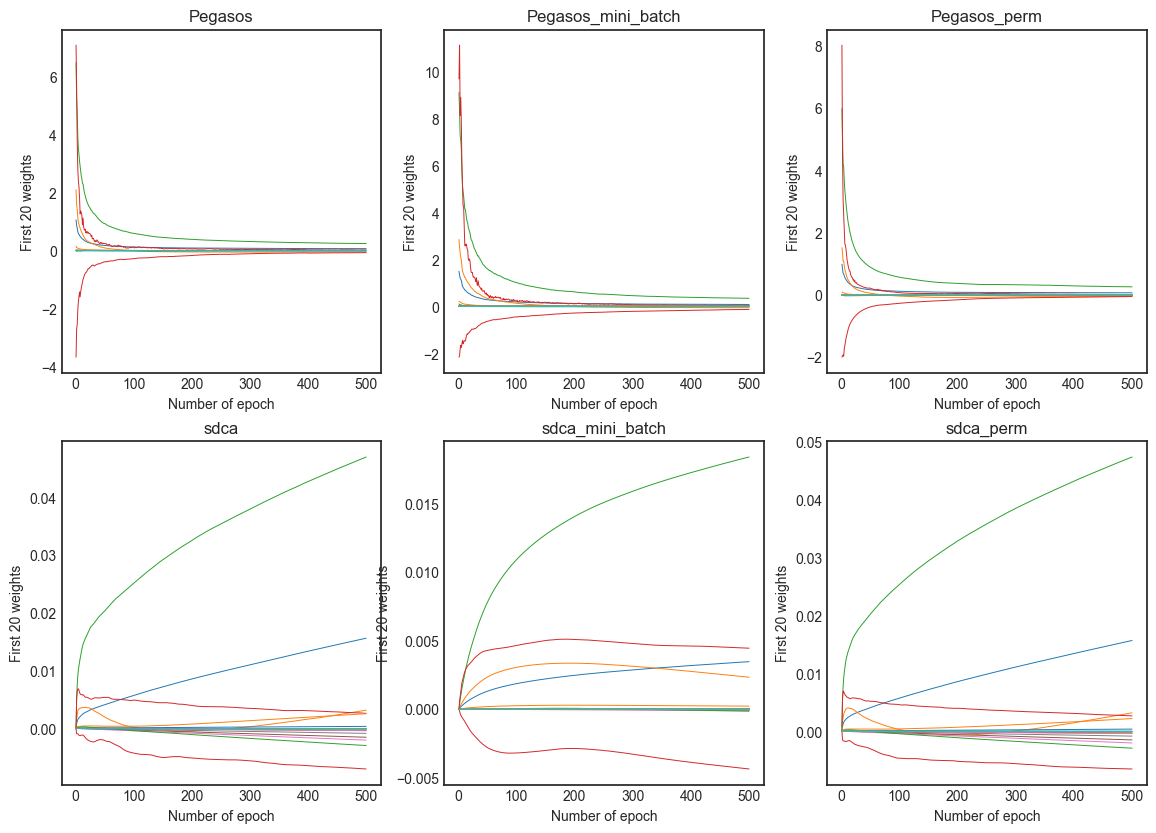

In [107]:
# Plot of the weights path depending on epoch
coef_dict = collections.OrderedDict(sorted(coef_dict.items()))
fig, axs = plt.subplots(2,3, figsize=(14, 10))

for i, j in coef_dict.items():
    for l in range(20):
        axs.flat[0:][np.where(np.array(list(coef_dict.keys()))==i)[0][0]].plot(np.arange(nb_epoch) + 1, [h[l] for h in j], lw=0.7)
        axs.flat[0:][np.where(np.array(list(coef_dict.keys()))==i)[0][0]].set_title(i)
        axs.flat[0:][np.where(np.array(list(coef_dict.keys()))==i)[0][0]].set_xlabel('Number of epoch')
        axs.flat[0:][np.where(np.array(list(coef_dict.keys()))==i)[0][0]].set_ylabel('First 20 weights')

We can see that weights yielded by Pegasos explode at first epochs and then decrease exponentially. In contrast, SDCA is more precise at the beginning. Notice that this analysis can be biased by the fact that the final coefficients are close to 0 (in the case of our dataset).

Now, let us look at the decrease of our penalized hinge loss ($\frac{1}{n} \sum\limits_{i=1}^n max(0,1-y_i w^Tx_i) + \frac{\lambda}{2}||w||^2$) and error rate (percentage of misclassified observations of our test set), according to the number of epochs.

In [70]:
def hinge_loss(y_pred, y_true, w, lambda_):
    return np.mean([max(0,i) for i in (1-pred_label*y_test)]) + lambda_/2 * np.linalg.norm(w)**2

In [71]:
error_dict = {'sdca': [], 'sdca_mini_batch': [], 'sdca_perm': [], 'Pegasos': [],
             'Pegasos_mini_batch': [], 'Pegasos_perm': []}
for i, j in coef_dict.items():
    for k in j:
        pred = k.dot(X_test.T)
        # Compute error rate
        pred_label = (pred > 0).astype(int)
        np.place(pred_label, pred_label==0, -1)
        error_dict[i].append((np.mean(pred_label != y_test), hinge_loss(pred_label, y_test, k, 0.1)))

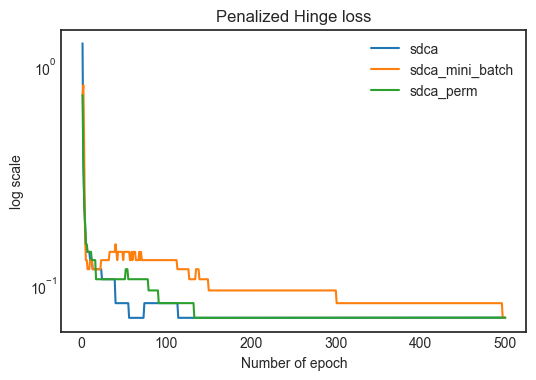

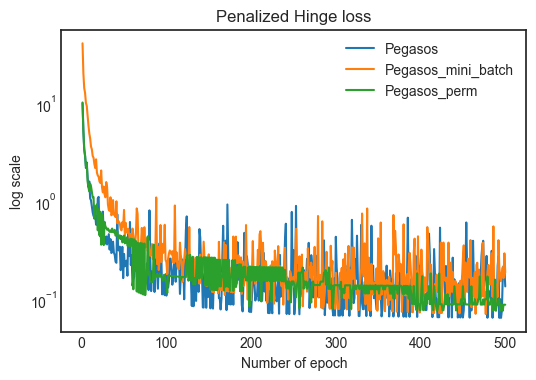

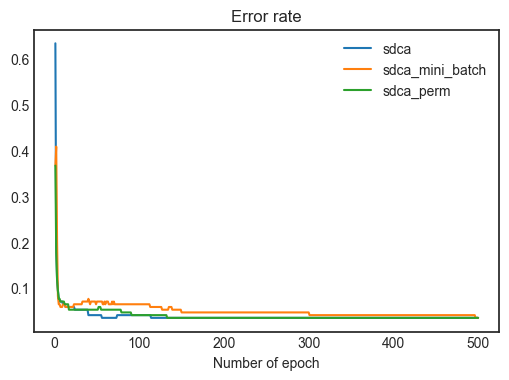

Text(0.5,0,'Number of epoch')

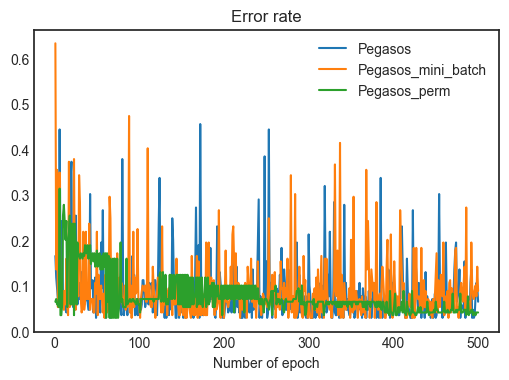

In [86]:
# Plot of loss and error rate path depending on epoch
error_dict = collections.OrderedDict(sorted(error_dict.items()))

plt.plot(np.arange(nb_epoch) + 1, [l[1] for l in error_dict['sdca']])
plt.plot(np.arange(nb_epoch) + 1, [l[1] for l in error_dict['sdca_mini_batch']])
plt.plot(np.arange(nb_epoch) + 1, [l[1] for l in error_dict['sdca_perm']])
plt.yscale('log')
plt.title('Penalized Hinge loss')
plt.legend(['sdca', 'sdca_mini_batch', 'sdca_perm'])
plt.xlabel('Number of epoch')
plt.ylabel('log scale')
plt.show()

plt.plot(np.arange(nb_epoch) + 1, [l[1] for l in error_dict['Pegasos']])
plt.plot(np.arange(nb_epoch) + 1, [l[1] for l in error_dict['Pegasos_mini_batch']])
plt.plot(np.arange(nb_epoch) + 1, [l[1] for l in error_dict['Pegasos_perm']])
plt.yscale('log')
plt.title('Penalized Hinge loss')
plt.legend(['Pegasos', 'Pegasos_mini_batch', 'Pegasos_perm'])
plt.xlabel('Number of epoch')
plt.ylabel('log scale')
plt.show()

plt.plot(np.arange(nb_epoch) + 1, [l[0] for l in error_dict['sdca']])
plt.plot(np.arange(nb_epoch) + 1, [l[0] for l in error_dict['sdca_mini_batch']])
plt.plot(np.arange(nb_epoch) + 1, [l[0] for l in error_dict['sdca_perm']])
plt.title('Error rate')
plt.legend(['sdca', 'sdca_mini_batch', 'sdca_perm'])
plt.xlabel('Number of epoch')
plt.show()

plt.plot(np.arange(nb_epoch) + 1, [l[0] for l in error_dict['Pegasos']])
plt.plot(np.arange(nb_epoch) + 1, [l[0] for l in error_dict['Pegasos_mini_batch']])
plt.plot(np.arange(nb_epoch) + 1, [l[0] for l in error_dict['Pegasos_perm']])
plt.title('Error rate')
plt.legend(['Pegasos', 'Pegasos_mini_batch', 'Pegasos_perm'])
plt.xlabel('Number of epoch')

In [126]:
for i, j in error_dict.items():
    print('Final error rate of {} --> {}%'.format(i, np.round(j[-1][0], 7)*100))

Final error rate of Pegasos --> 6.50888%
Final error rate of Pegasos_mini_batch --> 8.87574%
Final error rate of Pegasos_perm --> 4.14201%
Final error rate of sdca --> 3.5503%
Final error rate of sdca_mini_batch --> 3.5503%
Final error rate of sdca_perm --> 3.5503%


We can see that for each algorithm, the penalized Hinge loss decreases more slowly in mini-batch setting.

Notice that final losses are quiete similar whatever the optimization procedure used. We would expect that SDCA doesn't perform as well as Pegasos for the first epochs. However, using our setting (weights initialyzed at 0) and the specificity of our dataset, we observe the opposite. Indeed, the true coefficients being close to our cold start (weights initialyzed at 0), SDCA performs better than Pegasos at first epochs.

Regarding the error rate, SDCA performs better than Pegasos after 500 epochs. Then, again the mini-batch settings yield more errors during the optimization processes.

Finally, using decreasing steps sizes $\eta_t = \frac{1}{\lambda t}$ as suggested in the paper, we get hight variance in the Pegasos's results. We suspect the step size to be too high for our dataset. Thus, we reproduce the above results with $\eta_t = \frac{1}{\lambda t z}$ where $z = 1,2,3,4,5$.

100%|██████████| 500/500 [00:02<00:00, 217.94it/s]


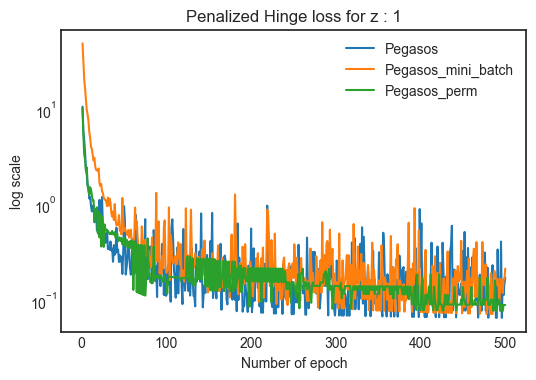

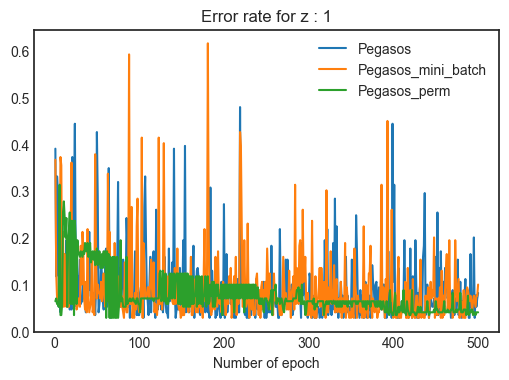

100%|██████████| 500/500 [00:02<00:00, 200.43it/s]


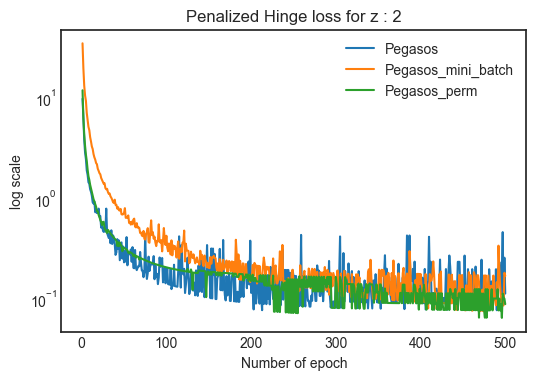

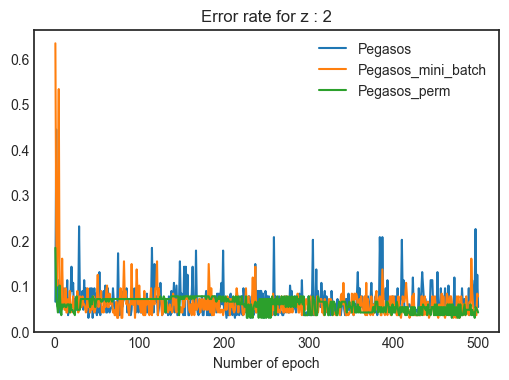

100%|██████████| 500/500 [00:02<00:00, 205.71it/s]


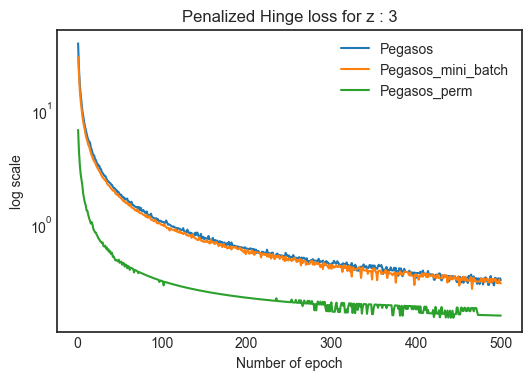

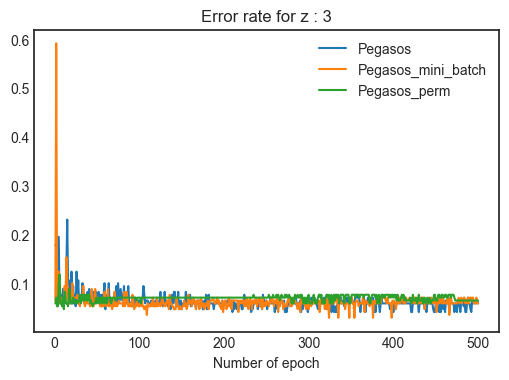

100%|██████████| 500/500 [00:02<00:00, 198.21it/s]


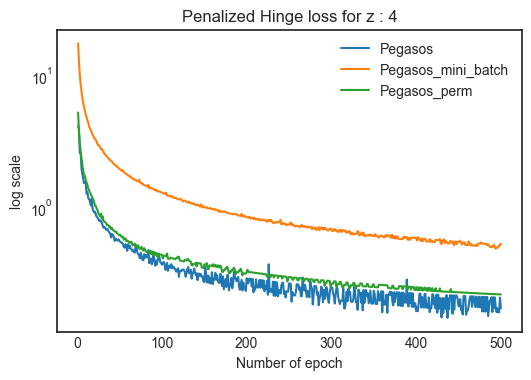

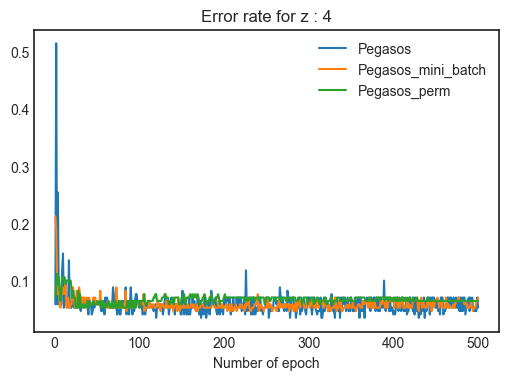

100%|██████████| 500/500 [00:02<00:00, 195.54it/s]


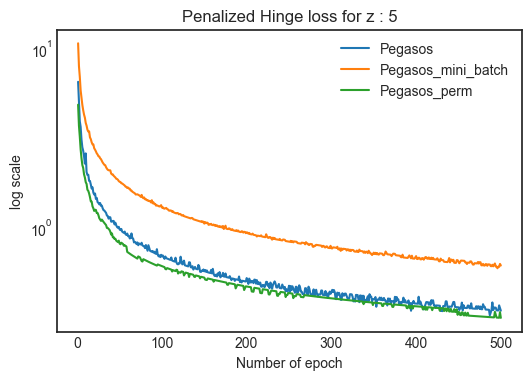

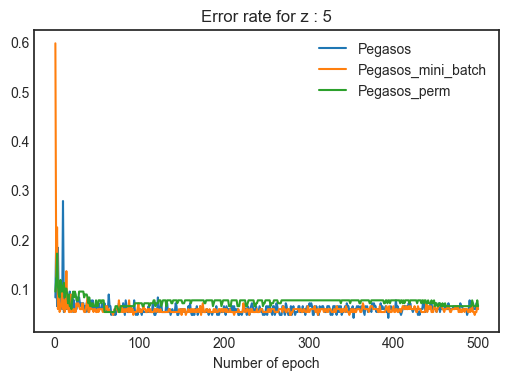

In [134]:
n = X_train.shape[0]
mini_batch_size = 10
nb_epoch = 500

for z in range(1,6):
    coef_dict = {'Pegasos': [],'Pegasos_mini_batch': [], 'Pegasos_perm': []}
    coef_dict['Pegasos'] = Pegasos(X_train, y_train, z, 1, nb_epoch*n, projection = False)
    coef_dict['Pegasos_mini_batch'] = Pegasos_mini_batch(X_train, y_train, z, mini_batch_size, 1, int(nb_epoch*n/mini_batch_size), projection = False)
    coef_dict['Pegasos_perm'] = Pegasos_perm(X_train, y_train, z, 1, nb_epoch, projection = False)
    # Compute error rate
    error_dict = {'Pegasos': [],'Pegasos_mini_batch': [], 'Pegasos_perm': []}
    for i, j in coef_dict.items():
        for k in j:
            pred = k.dot(X_test.T)
            # Compute error rate
            pred_label = (pred > 0).astype(int)
            np.place(pred_label, pred_label==0, -1)
            error_dict[i].append((np.mean(pred_label != y_test), hinge_loss(pred_label, y_test, k, 0.1)))
    # Do plots
    plt.plot(np.arange(nb_epoch) + 1, [l[1] for l in error_dict['Pegasos']])
    plt.plot(np.arange(nb_epoch) + 1, [l[1] for l in error_dict['Pegasos_mini_batch']])
    plt.plot(np.arange(nb_epoch) + 1, [l[1] for l in error_dict['Pegasos_perm']])
    plt.yscale('log')
    plt.title('Penalized Hinge loss for z : ' + str(z))
    plt.legend(['Pegasos', 'Pegasos_mini_batch', 'Pegasos_perm'])
    plt.xlabel('Number of epoch')
    plt.ylabel('log scale')
    plt.show()
    
    plt.plot(np.arange(nb_epoch) + 1, [l[0] for l in error_dict['Pegasos']])
    plt.plot(np.arange(nb_epoch) + 1, [l[0] for l in error_dict['Pegasos_mini_batch']])
    plt.plot(np.arange(nb_epoch) + 1, [l[0] for l in error_dict['Pegasos_perm']])
    plt.title('Error rate for z : ' + str(z))
    plt.legend(['Pegasos', 'Pegasos_mini_batch', 'Pegasos_perm'])
    plt.xlabel('Number of epoch')
    plt.show()

As expected, we can see that by diminushing the step size for the gradient descent, we decrease the variance of the results. Indeed, both penalized Hinge loss and error rate are less volatile when the step size is lower. In our case, we should rescale the step of the gradient descent by a factor of at least 3. In the case of Pegasos, we should pay a particular attention to the step's scale in order to control the variance of the results.

Evolution of the computational time depending on the number of epochs.

In [29]:
time_dict = {'sdca': [], 'sdca_mini_batch': [], 'sdca_perm': [], 'Pegasos': [],
             'Pegasos_mini_batch': [], 'Pegasos_perm': []}
for nb_epoch in range(50,501,50):
    # sdca time
    start_time = timeit.default_timer()
    SDCA(X_train, y_train, 0.01, nb_epoch*n, output = 'averaging')
    time_dict['sdca'].append(timeit.default_timer() - start_time)
    # sdca mini-batches
    SDCA_mini_batch(X_train, y_train, mini_batch_size, 0.01, 0.95, int(nb_epoch*n/mini_batch_size), output = 'averaging')
    time_dict['sdca_mini_batch'].append(timeit.default_timer() - start_time)
    # sdca time
    start_time = timeit.default_timer()
    SDCA_perm(X_train, y_train, 0.01, nb_epoch*n, output = 'averaging')
    time_dict['sdca_perm'].append(timeit.default_timer() - start_time)
    # sdca time
    start_time = timeit.default_timer()
    Pegasos(X_train, y_train, 0.01, nb_epoch*n, projection = False)
    time_dict['Pegasos'].append(timeit.default_timer() - start_time)
    # sdca time
    start_time = timeit.default_timer()
    Pegasos_mini_batch(X_train, y_train, mini_batch_size, 0.01, int(nb_epoch*n/mini_batch_size), projection = False)
    time_dict['Pegasos_mini_batch'].append(timeit.default_timer() - start_time)
    # sdca time
    start_time = timeit.default_timer()
    Pegasos_perm(X_train, y_train, 0.01, nb_epoch, projection = False)
    time_dict['Pegasos_perm'].append(timeit.default_timer() - start_time)

100%|██████████| 500/500 [00:02<00:00, 241.74it/s]


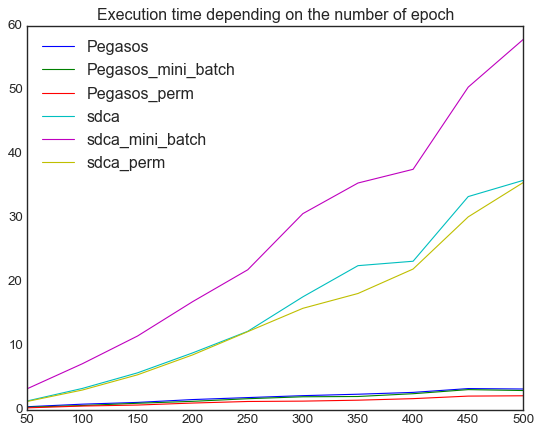

In [132]:
time_dict = collections.OrderedDict(sorted(time_dict.items()))

for i, j in time_dict.items():
    plt.plot([h for h in range(50,501,50)], j)
    plt.legend(time_dict.keys(), loc='upper left')
    plt.title('Execution time depending on the number of epoch')

In terms of computational time, Pegasos is clearly quicker than the SDCA algorithm. Notice that for SDCA, the mini-batches setting clearly stands out as the slower.

### 4] Conclusion

A ajouter:

- temps d'execution en fonction du nombre d'itérations

- Conclusion: Faire un commentaire sur temps d'exécution, compléxité du code (passer SDCA en mini batch chiant, passer des alpha aux poids à chaque fois c'est chiant aussi)

- Complexité de compréhension de l'algo

- Compléxité du paramétrage

- Qualité de l'optimisation, rapidité de convergence

In a nutshell (and according to the results we get on our dataset), we would recommend the use of Pegasos based algorithms instead of SDCA to solve SVM. Firstly, Pegasos algorithm is easier to understand since we work directly on weights. Moreover, the mini-batch setting is easier to implement whereas in the case of SDCA, the mini-batch setting is difficult to implement, and needs more parameters to set, which are not always easy to understand. A last advantage of Pegasos is the computational time. Indeed, SDCA is more time consuming. To run 500 epochs with our small dataset (400 lines and 30 features), Pegasos needs 4 seconds whereas SDCA needs 35 seconds. That is why for business's needs, we would recommend the use of Pegasos.

# BONUS

***
<center>___The kernalized Pegasos algorithm___</center>
***
___Let___ $\alpha^{(0)} = 0$<br>
___Iterate:___ for $t=1,2,...,T:$
>  Randomly pick $i$<br>
For all $j\neq i$:<br>
&nbsp;&nbsp;&nbsp;&nbsp; Set $\alpha_t[j] = \alpha_{t-1}[j]$<br>
If $y_i \frac{1}{\lambda t}\sum\limits_j \alpha_{t-1}[j]y_i K(x_i,x_j) < 1:$<br>
&nbsp;&nbsp;&nbsp;&nbsp; Set $\alpha_t[i] = \alpha_{t-1}[i]+1$<br>
Else:<br>
&nbsp;&nbsp;&nbsp;&nbsp; Set $\alpha_t[i] = \alpha_{t-1}[i]$<br>
 
___Output:___<br>
> return $\alpha_T$

***

In [16]:
kernels = {'linear_kernel':kernel.linear_kernel, 'polynomial_kernel':kernel.polynomial_kernel, 'rbf_kernel':kernel.rbf_kernel,
          'sigmoid_kernel':kernel.sigmoid_kernel, 'chi2_kernel':kernel.chi2_kernel}
def Pegasos_kernalized(X, y, kernel_choice = 'linear_kernel', lambda_ = 1, nb_iteration = 1000, projection = False):
    n = X.shape[0]
    alpha = [np.repeat(0, n)]
    ker_fun = kernels[kernel_choice]
    for t in tqdm(range(1,nb_iteration+1)):
        i = np.random.randint(0, n)
        j = [k for k in np.arange(n) if k!=i]
        if y[i]/(lambda_ * t) * sum([alpha[t-1][l] * y[i] * ker_fun(X[i].reshape(1, -1), X[l].reshape(1, -1)).item() for l in j]) < 1:
            e_i = np.zeros(n)
            e_i[i] = 1
            alpha.append(alpha[t-1]+e_i)
        else:
            alpha.append(alpha[t-1])
    return dual_primal(alpha[-1], X, lambda_)

In [17]:
Pegasos_kernalized_coefs = Pegasos_kernalized(X, y, 'linear_kernel', 1, 1000, projection = False)

100%|██████████| 1000/1000 [01:02<00:00, 16.10it/s]


In [18]:
np.linalg.norm(Pegasos_kernalized_coefs - sklearn_coefs, 2)

0.12720778759249748

The kernalized SVM solved thanks to kernalized Pegasos algorithm looses its performances compared to the non kernalized version. It seems that the kernalized version of Pegasos is not well suited to solve non-linear SVM if we cannot represent the kernel as a dot product of finite-dimensional feature vectors (i.e. it yields bad results when used with the RBF Kernel for example (which corresponds to infinite-dimensional feature vectors)).

See https://www.quora.com/Is-Pegasos-a-good-algorithm-for-non-linear-SVM